# Wifi Localization Problem Part3.2

* [0. Previous Preprocessing](#Preprocessing)
* [3. Predictions](#Predictions)
 * [3.1. Cascading Predictions](#Cascade)
     * [3.1.1. BuildingID](#BuildingID)
     * [3.1.2. Floor](#Floor)
     * [3.1.3. Latitude](#Latitude)
     * [3.1.4. Longitude](#Longitude)

In [1]:
#Load and import workspace
import dill
#dill.dump_session('notebook_session.db')
#dill.load_session('notebook_session.db')

In [2]:
#Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import statistics as st
import math
import scipy

#Import Models
import random
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.utils import resample

#Model Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

#Cross Validation
from sklearn.model_selection import train_test_split
from math import sqrt

In [3]:
#Import Datasets
wifi = pd.read_csv("./trainingData.csv") #the '.' is where you have the jupyter file
wifi_val = pd.read_csv("./validationData.csv")

# <a class="anchor" id="Preprocessing"> 0. Previous Preprocessing and Feat. Engineering </a>

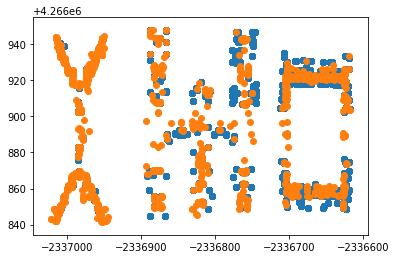

In [4]:
#### SCALE CHANGE ####

#Change scale of WAPs of TRAIN
wifi.iloc[:, 0:520] = np.where(wifi.iloc[:, 0:520] <= 0,
       wifi.iloc[:, 0:520] + 105,
       wifi.iloc[:, 0:520] - 100)

#Change scale of WAPs of VAL
wifi_val.iloc[:, 0:520] = np.where(
        wifi_val.iloc[:, 0:520] <= 0,  #0 or lower signals (to ignore 100s)
        wifi_val.iloc[:, 0:520] + 105, 
        wifi_val.iloc[:, 0:520] - 100)


#### ORIENTATION CHANGE #####

#TRAIN
angle = np.arctan(wifi["LATITUDE"][0]/wifi["LONGITUDE"][0])
angle = angle/math.pi
LONGITUDE = wifi["LONGITUDE"]*np.cos(angle) + wifi["LATITUDE"]*np.sin(angle)
LATITUDE = wifi["LATITUDE"]*np.cos(angle) - wifi["LONGITUDE"]*np.sin(angle)
plt.scatter(LONGITUDE,LATITUDE)
wifi["LONGITUDE"] = LONGITUDE
wifi["LATITUDE"] = LATITUDE
#VALIDATION
VLONGITUDE = wifi_val["LONGITUDE"]*np.cos(angle) +wifi_val["LATITUDE"]*np.sin(angle)
VLATITUDE = wifi_val["LATITUDE"]*np.cos(angle) - wifi_val["LONGITUDE"]*np.sin(angle)
wifi_val["LONGITUDE"] = VLONGITUDE
wifi_val["LATITUDE"] = VLATITUDE
plt.scatter(VLONGITUDE,VLATITUDE)
plt.show()

#### DELETE COLUMNS #####

del wifi['RELATIVEPOSITION']
del wifi['USERID']
del wifi['TIMESTAMP']
del wifi_val['RELATIVEPOSITION']
del wifi_val['USERID']
del wifi_val['TIMESTAMP']

#### PROBLEMATIC PHONES #####

Phones_T = [7,8,11,17,19]
wifi = wifi[~wifi.PHONEID.isin(Phones_T)]

Phones_V = [5,12,14,21]
wifi_val = wifi_val[~wifi_val.PHONEID.isin(Phones_V)]

#Note: we need to do this before removing duplicated rows

#### DUPLICATED ROWS #####

wifi = wifi.drop_duplicates(subset=None, keep='first',inplace=False) 
#754 repeated rows removed (all from train)

#### STRANGE AND LOW SIGNALS #####

wifi.iloc[:, 0:520] = wifi.iloc[:, 0:520].replace(np.r_[1:9], 10) 
wifi_val.iloc[:, 0:520] = wifi_val.iloc[:, 0:520].replace(np.r_[1:9], 10) 
#Turn useless signals to a single useless number (10)

wifi.iloc[:, 0:520] = wifi.iloc[:, 0:520].replace(np.r_[71:106], 70)
wifi_val.iloc[:, 0:520] = wifi_val.iloc[:, 0:520].replace(np.r_[71:106], 70)
#Reduce perfect signals above 70 to 70.

#### NEW WAP AVERAGE COLUMN #####

#maxWAPvalue = wifi_trainval.iloc[:,0:520].max(axis=1)
#Note: this messes up the model

# <a class="anchor" id="Predictions"> 3. Predictions </a>

Two approaches make the most sense:
1. Training on the 'train set' without splitting and testing on the 'validation set'
2. Merging 'train' and 'validation set', splitting, and testing on ~30% of the data.

In this case, we are using **Approach no. 1** (split train and test on validation)

### <a class="anchor" id="BuildingID"> 3.1.1. BuildingID </a>

### Logistic Regression (Classification)

95.0 confidence interval 98.9% and 100.0%


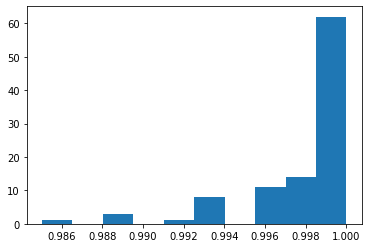

In [26]:
#No Split
x_train = wifi.iloc[:,0:520]
y_train = wifi.iloc[:,np.r_[520:524]]
x_test = wifi_val.iloc[:,0:520]
y_test = wifi_val.iloc[:,np.r_[520:524]]
train = pd.concat([x_train, y_train['BUILDINGID']], axis=1)
test = pd.concat([x_test, y_test['BUILDINGID']], axis=1)

#Configure Bootstrap
n_iterations = 100
buildingaccuracyscores = []
buildingkappascores    = []

for i in range(n_iterations):
    
   #Prepare train and test sets
   trains = resample(train, n_samples = int(len(train) * 0.50))
   tests  = resample(test, n_samples = int(len(test) * 0.50))

   #Fit model
   model = LogisticRegression(
    random_state=0, solver='lbfgs', multi_class='multinomial').fit(trains.iloc[:,:-1], trains.iloc[:,-1])
    
   #Evaluate model
   predictions = model.predict(tests.iloc[:,:-1])
   score1 = accuracy_score(tests.iloc[:,-1], predictions)
   score2 = cohen_kappa_score(tests.iloc[:,-1], predictions)
   buildingaccuracyscores.append(score1)
   buildingkappascores.append(score2)

plt.hist(buildingaccuracyscores)

alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lowerbuildacc = max(0.0, np.percentile(buildingaccuracyscores, p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upperbuildacc = min(1.0, np.percentile(buildingaccuracyscores, p))
print('%.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, lowerbuildacc*100, upperbuildacc*100))

### <a class="anchor" id="Floor"> 3.1.2. Floor </a>

95.0 confidence interval 84.9% and 90.7%


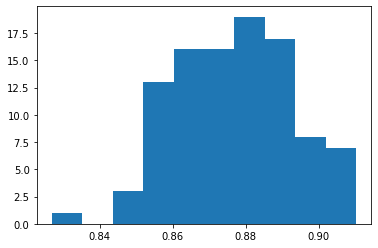

In [27]:
#No Split
x_train = wifi.iloc[:,0:520]
y_train = wifi.iloc[:,np.r_[520:524]]
x_test = wifi_val.iloc[:,0:520]
y_test = wifi_val.iloc[:,np.r_[520:524]]
train = pd.concat([x_train, y_train['FLOOR']], axis=1)
test = pd.concat([x_test, y_test['FLOOR']], axis=1)

#Configure Bootstrap
n_iterations = 100
flooraccuracyscores = []
floorkappascores    = []

for i in range(n_iterations): 
   #Prepare train and test sets
   trains = resample(train, n_samples = int(len(train) * 0.50))
   tests  = resample(test, n_samples = int(len(test) * 0.50))
   #Fit model
   model = KNeighborsClassifier(n_neighbors=7).fit(trains.iloc[:,:-1], trains.iloc[:,-1])    
   #Evaluate model
   predictions = model.predict(tests.iloc[:,:-1])
   score1 = accuracy_score(tests.iloc[:,-1], predictions)
   score2 = cohen_kappa_score(tests.iloc[:,-1], predictions)
   flooraccuracyscores.append(score1)
   floorkappascores.append(score2)

plt.hist(flooraccuracyscores)

alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lowerflooracc = max(0.0, np.percentile(flooraccuracyscores, p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upperflooracc = min(1.0, np.percentile(flooraccuracyscores, p))
print('%.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, lowerflooracc*100, upperflooracc*100))

### <a class="anchor" id="Latitude"> 3.1.3. Latitude </a>

RMSE is  8.838077985395826 with +/- 0.6581378665613686
MAE is  5.348299023384391 with +/- 0.3159840925115682
R2 is  0.9272054383426798 with +/- 0.010954592197730343


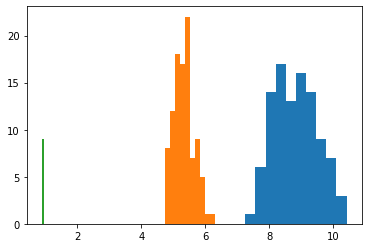

In [30]:
#No Split
x_train = wifi.iloc[:,0:520]
y_train = wifi.iloc[:,np.r_[520:524]]
x_test = wifi_val.iloc[:,0:520]
y_test = wifi_val.iloc[:,np.r_[520:524]]
train = pd.concat([x_train, y_train['LATITUDE']], axis=1)
test = pd.concat([x_test, y_test['LATITUDE']], axis=1)

#Configure Bootstrap
n_iterations = 100
latRMSE = []
latMAE  = []
latR2   = []

for i in range(n_iterations):
   #Prepare train and test sets
   trains = resample(train, n_samples = int(len(train) * 0.50))
   tests  = resample(test, n_samples = int(len(test) * 0.50))
   #Fit model
   model = KNeighborsRegressor(n_neighbors=10)
   model.fit(trains.iloc[:,:-1], trains.iloc[:,-1])
   #Evaluate model
   predictions = model.predict(tests.iloc[:,:-1])
   score1 = sqrt(mean_squared_error(tests.iloc[:,-1], predictions))
   score2 = mean_absolute_error(tests.iloc[:,-1], predictions)
   score3 = r2_score(tests.iloc[:,-1], predictions)
   longRMSE.append(score1)
   longMAE.append(score2)
   longR2.append(score3)


plt.hist(latRMSE)
plt.hist(latMAE)
plt.hist(latR2)

devlatRMSE = st.stdev(latRMSE)
devlatMAE = st.stdev(latMAE)
devlatR2 = st.stdev(latR2)
meanlatRMSE = st.mean(latRMSE)
meanlatMAE  = st.mean(latMAE)
meanlatR2   = st.mean(latR2)
print("RMSE is ", meanlongRMSE, "with +/-",devlatRMSE)
print("MAE is ", meanlongMAE, "with +/-",devlatMAE)
print("R2 is ", meanlongR2, "with +/-",devlatR2)

### <a class="anchor" id="Longitude"> 3.1.4. Longitude </a>

RMSE is  16.596715245608763 with +/- 4.6935882490245735
MAE is  6.716893610896097 with +/- 1.03779999607732
R2 is  0.9835702224795249 with +/- 0.009454573932249771


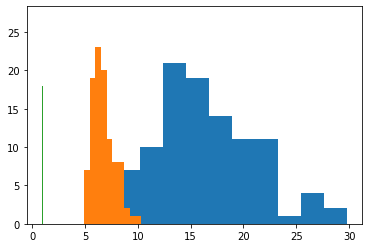

In [31]:
#No Split
x_train = wifi.iloc[:,0:520]
y_train = wifi.iloc[:,np.r_[520:524]]
x_test = wifi_val.iloc[:,0:520]
y_test = wifi_val.iloc[:,np.r_[520:524]]
train = pd.concat([x_train, y_train['LONGITUDE']], axis=1)
test = pd.concat([x_test, y_test['LONGITUDE']], axis=1)

#Configure Bootstrap
n_iterations = 100
longRMSE = []
longMAE  = []
longR2   = []

for i in range(n_iterations):
   #Prepare train and test sets
   trains = resample(train, n_samples = int(len(train) * 0.50))
   tests  = resample(test, n_samples = int(len(test) * 0.50))
   #Fit model
   model = KNeighborsRegressor(n_neighbors=7)
   model.fit(trains.iloc[:,:-1], trains.iloc[:,-1])
   #Evaluate model
   predictions = model.predict(tests.iloc[:,:-1])
   score1 = sqrt(mean_squared_error(tests.iloc[:,-1], predictions))
   score2 = mean_absolute_error(tests.iloc[:,-1], predictions)
   score3 = r2_score(tests.iloc[:,-1], predictions)
   longRMSE.append(score1)
   longMAE.append(score2)
   longR2.append(score3)


plt.hist(longRMSE)
plt.hist(longMAE)
plt.hist(longR2)

devlongRMSE = st.stdev(longRMSE)
devlongMAE = st.stdev(longMAE)
devlongR2 = st.stdev(longR2)
meanlongRMSE = st.mean(longRMSE)
meanlongMAE  = st.mean(longMAE)
meanlongR2   = st.mean(longR2)
print("RMSE is ", meanlongRMSE, "with +/-",devlongRMSE)
print("MAE is ", meanlongMAE, "with +/-",devlongMAE)
print("R2 is ", meanlongR2, "with +/-",devlongR2)